In [1]:
import torch
import math
import matplotlib.pyplot as plt

from torch import cuda
from scheduler import CustomScheduler
from model import EAST
from torch.optim.lr_scheduler import _LRScheduler

In [2]:

model = EAST()
model.to("cuda" if cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

max_epoch = 50

# Step LR의 학습률을 2번 하락으로 변경
scheduler_params = {
    "optimizer": optimizer,
    "T_max": max_epoch//3 + (1 if max_epoch%3 else 0),
    "eta_min": 0.00001,
    "verbose": False,
}
# CustomScheduler로 설정
scheduler = CustomScheduler(
    scheduler_name="CosineAnnealingLR", params=scheduler_params
)

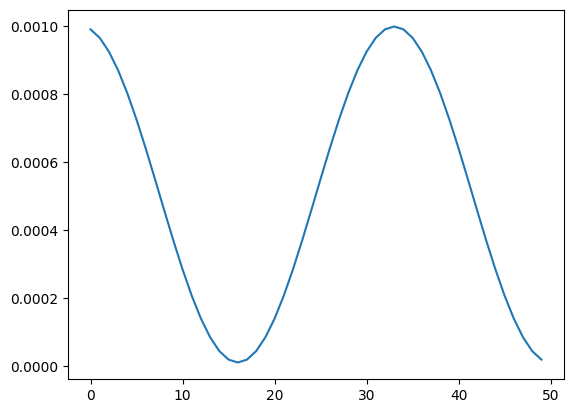

In [3]:
lrs = []
for epoch in range(max_epoch):
    for i in range(13):
        optimizer.zero_grad()
        optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)
fig, ax = plt.subplots()
ax.plot(lrs)
plt.show()

In [4]:
max_epoch = 60

# Step LR의 학습률을 2번 하락으로 변경
scheduler_params = {
    "optimizer": optimizer,
    "T_0": max_epoch // 3 + (1 if max_epoch % 3 else 0),
    "T_mult": 1,
    "eta_min": 0.00001,
    "verbose": False,
}
# CustomScheduler로 설정
scheduler = CustomScheduler(
    scheduler_name="CosineAnnealingWarmRestarts", params=scheduler_params
)

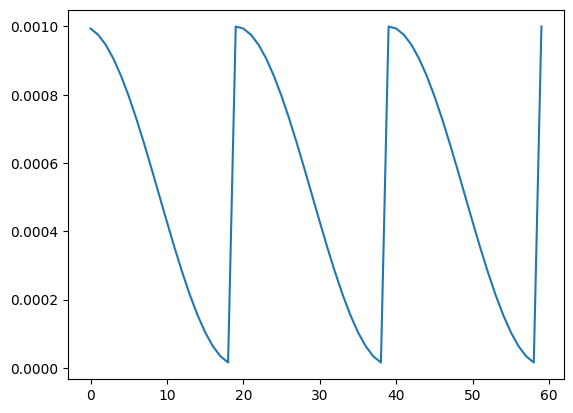

In [5]:
lrs = []
for epoch in range(max_epoch):
    for i in range(13):
        optimizer.zero_grad()
        optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)
fig, ax = plt.subplots()
ax.plot(lrs)
plt.show()

In [6]:
class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [7]:
max_epoch = 130

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=max_epoch // 2, T_mult=1, eta_max=0.001,  T_up=1, gamma=0.5)

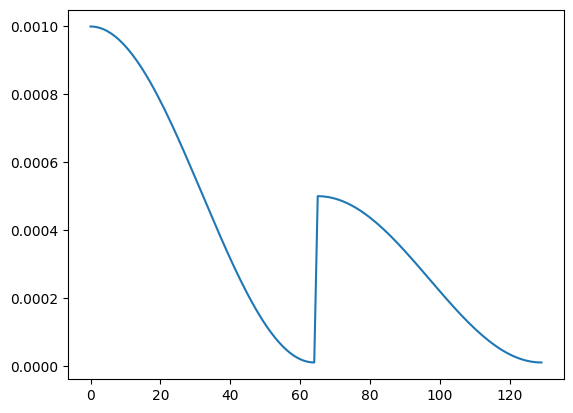

In [8]:
lrs = []
for epoch in range(max_epoch):
    for i in range(13):
        optimizer.zero_grad()
        optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)
fig, ax = plt.subplots()
ax.plot(lrs)
plt.show()

In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.optimizer import Optimizer

class Custom_CosAnn(_LRScheduler):
    def __init__(self, optimizer: Optimizer, fix_epoch, T_max: int, eta_min: float = ..., last_epoch: int = ...) -> None:
        self.cosAnn = CosineAnnealingLR(optimizer=optimizer, T_max=T_max, eta_min=eta_min, last_epoch=last_epoch)
        self.fix_epoch = fix_epoch
    def step(self, epoch) -> None:
        if epoch >= self.fix_epoch:
            return self.cosAnn.step()

In [10]:
max_epoch = 130

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler_params = {
    "optimizer": optimizer,
    "fix_epoch": max_epoch//2,
    "T_max": max_epoch - max_epoch//2,
    "eta_min": 0.0001,
    "last_epoch": -1
}
scheduler = Custom_CosAnn(**scheduler_params)

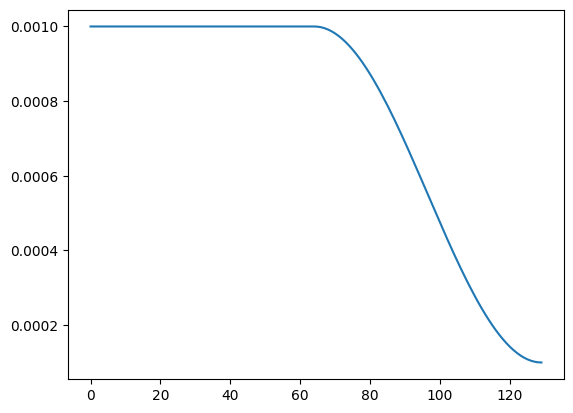

In [11]:
lrs = []
for epoch in range(max_epoch):
    for i in range(13):
        optimizer.zero_grad()
        optimizer.step()
    scheduler.step(epoch=epoch)
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)
fig, ax = plt.subplots()
ax.plot(lrs)
plt.show()

In [12]:
max_epoch = 130

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler_params = {
    "optimizer": optimizer,
    "fix_epoch": max_epoch//2,
    "T_max": max_epoch - max_epoch//2,
    "eta_min": 0.0001,
    "last_epoch": -1
}
scheduler = Custom_CosAnn(**scheduler_params)

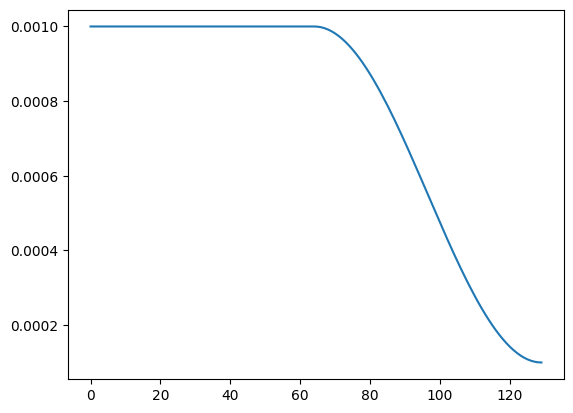

In [13]:
lrs = []
for epoch in range(max_epoch):
    for i in range(13):
        optimizer.zero_grad()
        optimizer.step()
    scheduler.step(epoch=epoch)
    current_lr = optimizer.param_groups[0]["lr"]
    lrs.append(current_lr)
fig, ax = plt.subplots()
ax.plot(lrs)
plt.show()